In [21]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [22]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function_goku_pre_frontera.txt', unpack=True, usecols=(0,1,2))

In [23]:
# extract n_LF < 60
'''n_LF_thres = 60
n_LF_new = []
n_HF_new = []
rel_err_new = []
for i in range(len(n_LF)):
    if n_LF[i] < n_LF_thres:
        n_LF_new.append(n_LF[i])
        n_HF_new.append(n_HF[i])
        rel_err_new.append(rel_error[i])
n_LF = np.array(n_LF_new)
n_HF = np.array(n_HF_new)
rel_error = np.array(rel_err_new)'''

'n_LF_thres = 60\nn_LF_new = []\nn_HF_new = []\nrel_err_new = []\nfor i in range(len(n_LF)):\n    if n_LF[i] < n_LF_thres:\n        n_LF_new.append(n_LF[i])\n        n_HF_new.append(n_HF[i])\n        rel_err_new.append(rel_error[i])\nn_LF = np.array(n_LF_new)\nn_HF = np.array(n_HF_new)\nrel_error = np.array(rel_err_new)'

In [24]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [25]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=10, sigma=.3)
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=0, sigma=1)
    beta_L = pm.Normal("beta_L", mu=1, sigma=.2)
    beta_H = pm.Normal("beta_H", mu=1, sigma=.2)
    # rho_2 = pm.Uniform("rho_2", lower=0, upper=1)
    beta_H2 = pm.Normal("beta_H2", mu=3, sigma=1)
    alpha_1 = pm.Normal("alpha_1", mu=10, sigma=5)
    alpha_2 = pm.Normal("alpha_2", mu=30, sigma=5)
    # rho_H = pm.Normal("rho_H", mu=1, sigma=.2)
    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * (n_HF**(beta_H) + alpha_1)) + 1 / (alpha_2 + n_HF**(beta_H2))))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=np.log10(rel_error))

In [26]:
error_mean

0.07691774833501684

In [27]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(6000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, beta_H2, alpha_1, alpha_2, sigma]


Output()

Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 42 seconds.


In [28]:
dict(idata)

{'posterior': <xarray.Dataset> Size: 2MB
 Dimensions:  (chain: 4, draw: 6000)
 Coordinates:
   * chain    (chain) int64 32B 0 1 2 3
   * draw     (draw) int64 48kB 0 1 2 3 4 5 6 ... 5994 5995 5996 5997 5998 5999
 Data variables:
     alpha_1  (chain, draw) float64 192kB 36.65 36.67 34.05 ... 41.48 43.06 39.25
     alpha_2  (chain, draw) float64 192kB 33.98 31.65 35.7 ... 27.85 34.62 25.28
     beta_H   (chain, draw) float64 192kB 1.898 1.923 1.881 ... 1.946 1.932 1.933
     beta_H2  (chain, draw) float64 192kB 6.734 6.816 6.421 ... 6.466 6.323 6.936
     beta_L   (chain, draw) float64 192kB 0.8023 0.7988 0.8378 ... 0.8583 0.8198
     eta      (chain, draw) float64 192kB 9.847 10.07 9.964 ... 9.99 9.964 10.02
     rho      (chain, draw) float64 192kB 28.32 27.85 30.7 ... 38.95 40.07 32.82
     sigma    (chain, draw) float64 192kB 0.228 0.2241 0.2257 ... 0.2187 0.2284
 Attributes:
     created_at:                 2024-07-03T00:51:52.663421+00:00
     arviz_version:              0.18.0
  

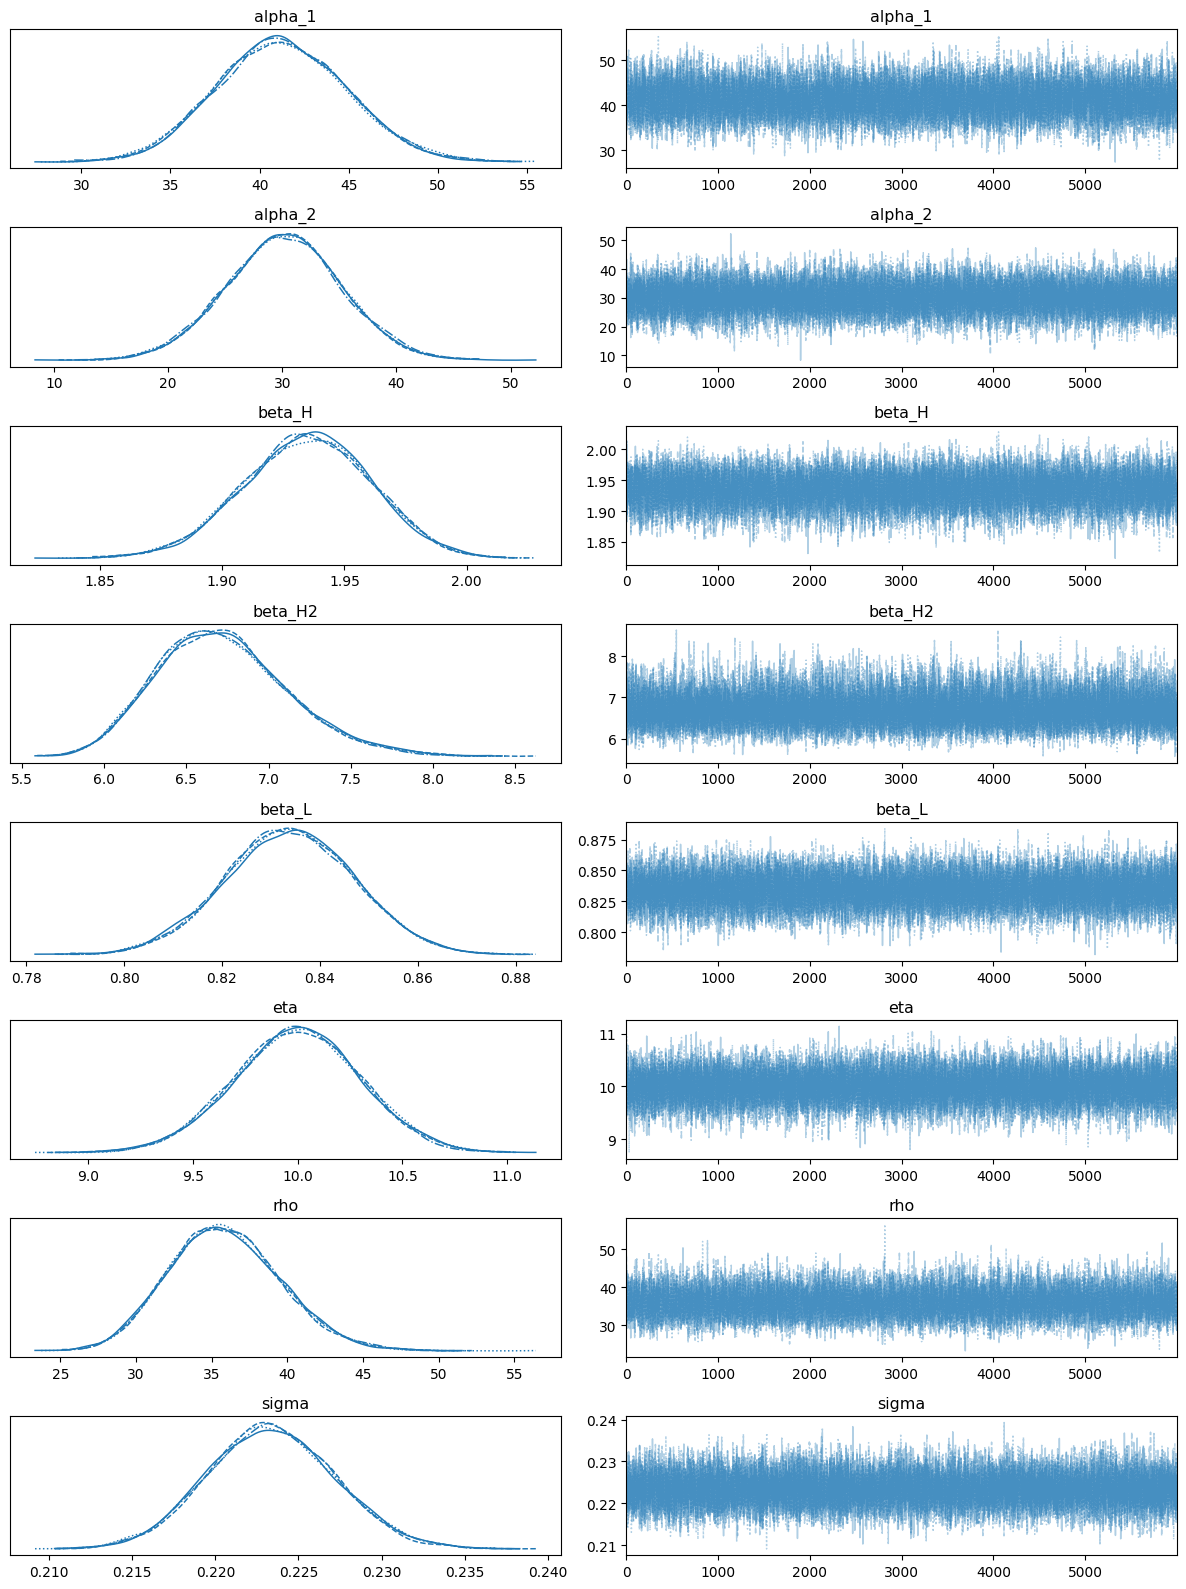

In [29]:
az.plot_trace(idata)
plt.tight_layout()

In [30]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[ 9.69954997 10.00035994 10.29655047]
[32.20159091 35.70383238 39.52132335]
[0.82093783 0.83398061 0.84700858]
[1.90830565 1.93499795 1.96063786]


In [31]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_1,41.238,3.655,34.340,48.026,0.031,0.022,14191.634,15532.771,1.000
alpha_2,30.125,5.024,20.715,39.599,0.029,0.021,29358.614,16235.506,1.000
beta_H,1.935,0.026,1.886,1.983,0.000,0.000,13764.387,16065.767,1.000
beta_H2,6.722,0.400,5.998,7.475,0.003,0.002,25488.701,14484.885,1.000
beta_L,0.834,0.013,0.810,0.859,0.000,0.000,20030.930,17215.740,1.000
eta,9.998,0.300,9.444,10.572,0.002,0.001,26784.574,15803.380,1.000
rho,35.864,3.654,29.147,42.762,0.032,0.023,12720.155,13736.210,1.001
sigma,0.223,0.004,0.217,0.231,0.000,0.000,28421.863,16992.449,1.000


In [32]:
posterior_eta.values.flatten()

array([ 9.846943  , 10.06928935,  9.96442205, ...,  9.98968979,
        9.96358474, 10.01775558])

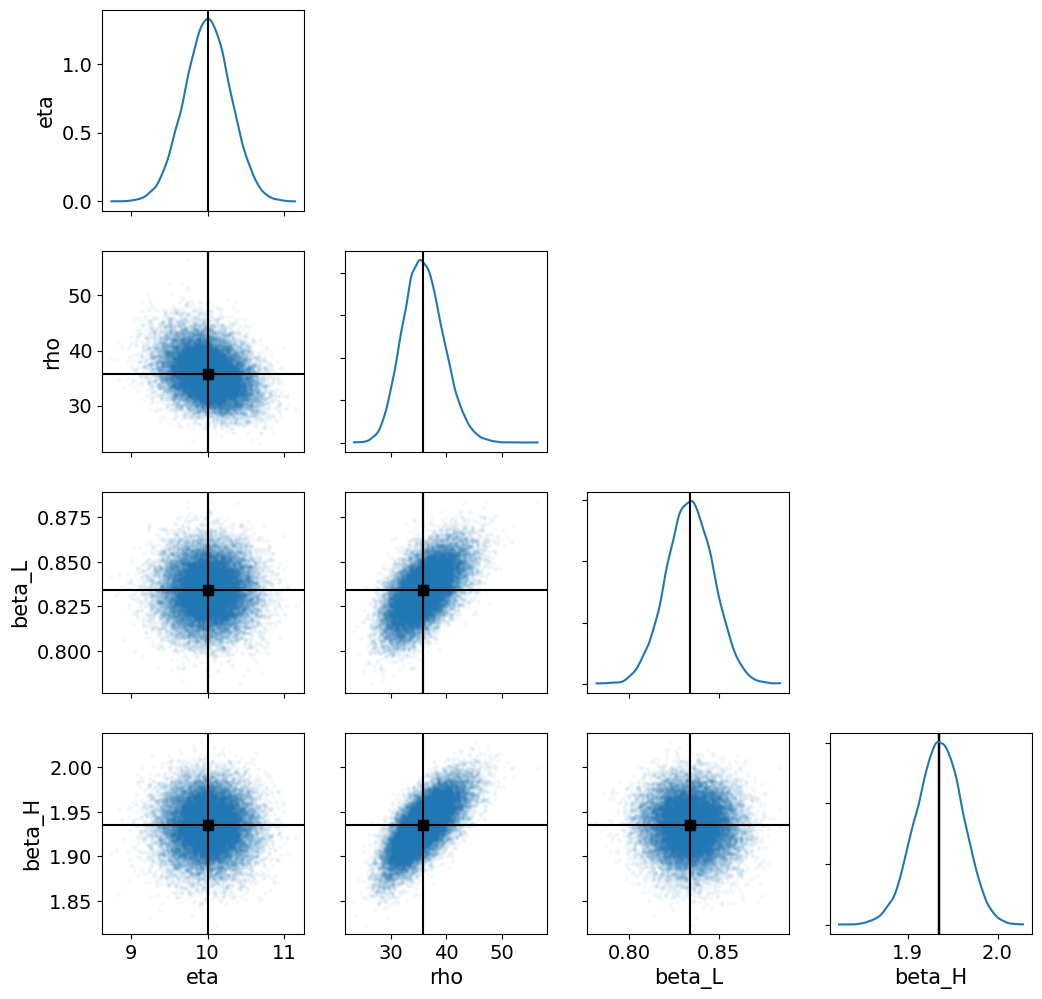

In [33]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [34]:
# loss  mean
eta_mean = np.mean(idata["posterior"]["eta"].values)
rho_mean = np.mean(idata["posterior"]["rho"].values)
beta_L_mean = np.mean(idata["posterior"]["beta_L"].values)
beta_H_mean = np.mean(idata["posterior"]["beta_H"].values)

phi = eta_mean * (rho_mean * n_LF**(-beta_L_mean) + n_HF**(-beta_H_mean))
loss = np.mean((phi - rel_error)**2)

In [35]:
loss

426.39269314283337

In [36]:
# define the error function
def error_function(n_LF, n_HF):
    eta = 28 * .8
    rho = .96
    beta_L = .86 * 1.
    beta_H = 1.1
    alpha = 37
    beta_H2 = 2.06
    return 10**(np.log10(eta) + np.log10((rho / (n_LF**(beta_L) * n_HF**(beta_H)) + (1 - rho) / (alpha + n_HF**(beta_H2)))))

phi = error_function(n_LF, n_HF)
loss = np.mean((np.log(phi) - rel_error)**2)

In [37]:
loss

14.410891845928958

In [38]:
type(idata["posterior"]["eta"])

xarray.core.dataarray.DataArray

In [39]:
# define the error function
def error_function(n_LF, n_HF):
    eta = 0.55464788
    rho = 2.42445591
    beta_L = 0.71932452
    beta_H = 1.40160385
    return eta * (rho * n_LF**(-beta_L) + n_HF**(-beta_H))


In [40]:
error_function(60, 9)

0.09622394048841161